<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 re

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

for document in tqdm(dataset['train']['text']):
  tokenize_document = sent_tokenize(document, language='english')

  for sentence in tokenize_document:
    if len(word_tokenize(sentence)) >= word_threshold:
      sentences.append(sentence.lower())
# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))
print(dataset["train"]["text"][0])
print(sentences[0])

Всего предложений: 72256
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are

Посчитаем для каждого слова его встречаемость.

In [8]:
words = Counter()

for sentence in tqdm(sentences):
  for word in word_tokenize(sentence):
    words[word] += 1

  0%|          | 0/72256 [00:00<?, ?it/s]

In [9]:
print(len(words))

87302


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 5000

print(f"Начальный размер vocab: {len(vocab)}")
for word, cnt in sorted(words.items(), key=lambda x: x[1], reverse=True):
  if len(vocab) >= (vocab_size + 4):
    break
  vocab.add(word)

print(f"Финальный размер vocab: {len(vocab)}")

Начальный размер vocab: 4
Финальный размер vocab: 5004


In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 5004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        words = word_tokenize(self.data[idx])
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in words]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [20]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

**В коде выше неправильно проведено деление на train, eval, test.** Следствие: модель будет видеть одни и те же данные и в обучении, и в тестировании. Она "запоминит" ответы вместо того, чтобы обобщать

Сделаем другое разделение, и продолжим обучение на его основе.

In [16]:
train_eval_sentences, test_sentences = train_test_split(sentences, test_size=0.2)
train_sentences, eval_sentences = train_test_split(train_eval_sentences, test_size=0.25)

batch_size = 64

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [39]:
def train_model(train_dataloader, model, optimizer, criterion, num_epoch ):
  losses = []
  perplexities = []

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc= f'Training epoch {epoch}:'):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits.reshape(-1, logits.size(-1)), batch['target_ids'].reshape(-1))
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses)/ len(epoch_losses))
    perplexities.append(evaluate(model, criterion, eval_dataloader))
  return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [40]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection= self.projection(self.non_lin(output))

        return projection

In [41]:
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [42]:
losses, perplexities = train_model(train_dataloader, model, optimizer, criterion, 20)

Training epoch 0::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/678 [00:00<?, ?it/s]

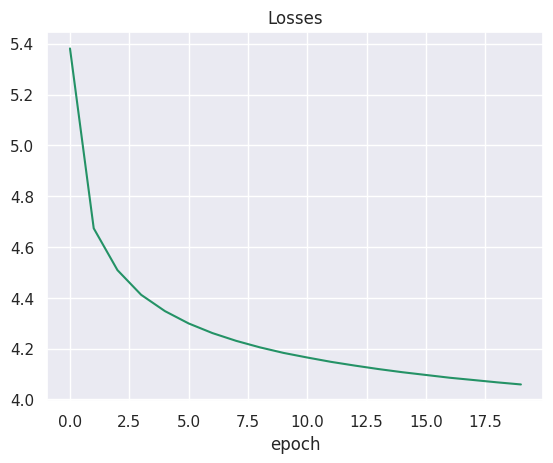

In [43]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

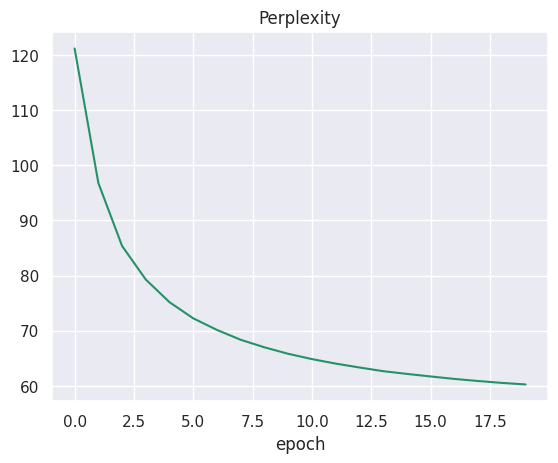

In [44]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

**1) Попробуем искпользовать GRU**, а не LSTM, так как LSTM дает большую точность по сравнению с GRU и RNN именно в архитектурах, в данном случае не получается запускать на GPU модель с более чем одним слоем

In [26]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection= self.projection(self.non_lin(output))

        return projection

In [27]:
model2 = LanguageModel(hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion2 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer2 = torch.optim.Adam(model2.parameters())

In [28]:
losses2, perplexities2 = train_model(train_dataloader, model2, optimizer2, criterion2, 20)

Training epoch 0::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/678 [00:00<?, ?it/s]

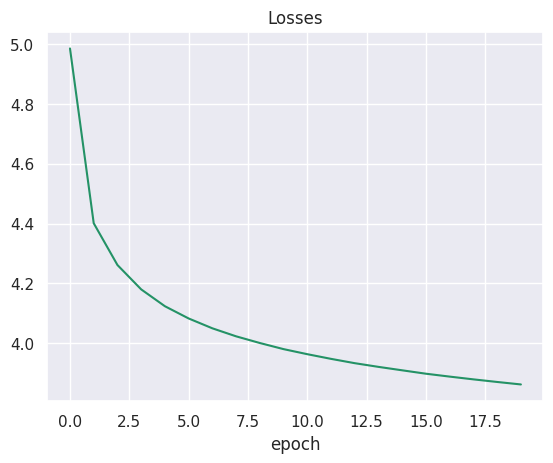

In [29]:
plt.plot(np.arange(len(losses2)), losses2)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

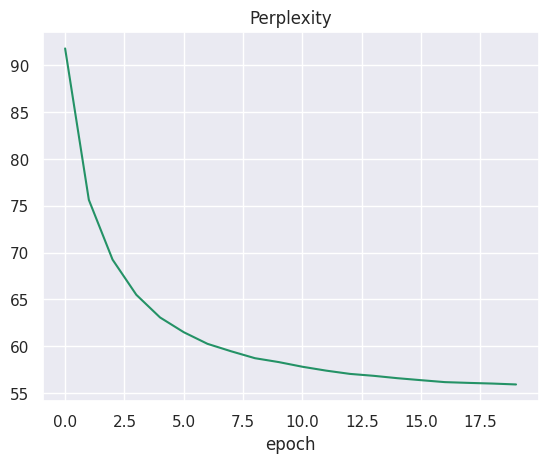

In [30]:
plt.plot(np.arange(len(perplexities2)), perplexities2)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


**2) Видим, что модель GRU справилась чуть лучше, чем LSTM. Попробуем усовершенствовать GRU


**Увеличим размер скрытого пространства** Таким образом модель сможет запомнить более сложные паттерны.
**Добавим еще нормализацию**

In [21]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        output = self.layer_norm1(output)
        output = self.non_lin(output)
        output = self.linear(output)
        output = self.dropout(output)
    
        output = self.layer_norm2(output)
        output = self.non_lin(output)
        projection = self.projection(output)
    
        return projection

In [22]:
model1 = LanguageModel(hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion1 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer1 = torch.optim.Adam(model1.parameters())

In [23]:
losses1, perplexities1 = train_model(train_dataloader, model1, optimizer1, criterion1, 20)

Training epoch 0::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/678 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/678 [00:00<?, ?it/s]

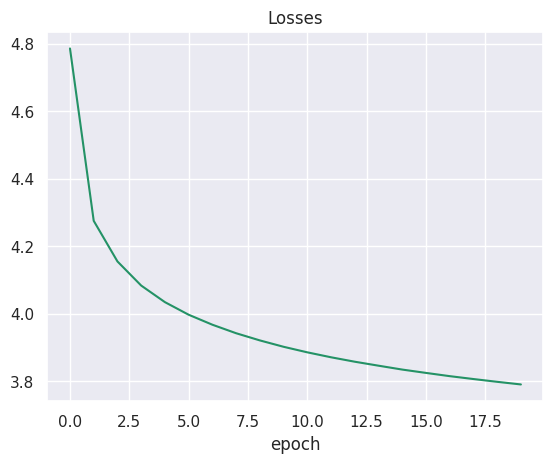

In [24]:
plt.plot(np.arange(len(losses1)), losses1)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

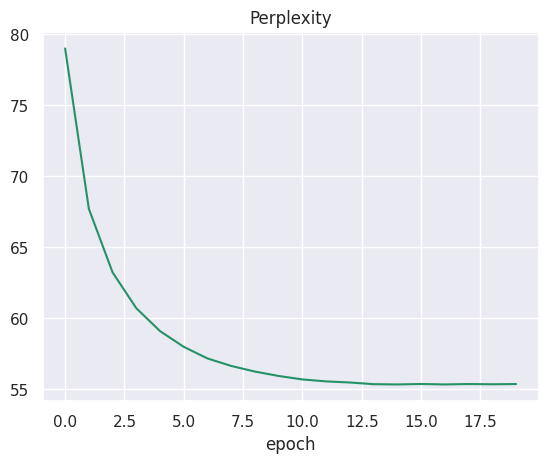

In [25]:
plt.plot(np.arange(len(perplexities1)), perplexities1)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

Видим, что усовершенствованная модель справляется чуть лучше предыдущей. **Попробуем обучить LSTM и увеличить кол-во слоев, добавим Learning Rate Scheduling** 

In [33]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers =2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection= self.projection(self.non_lin(output))

        return projection

In [32]:
def train_model(train_dataloader, model, optimizer, criterion, num_epoch, scheduler=None):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits.reshape(-1, logits.size(-1)), batch['target_ids'].reshape(-1))
            loss.backward()
            
            # Градиентный клиппинг (рекомендуется добавить)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)
        
       
        perplexity = evaluate(model, criterion, eval_dataloader)
        perplexities.append(perplexity)
        
        # SCHEDULER.STEP()
        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch {epoch}: Loss = {avg_loss:.4f}, Perplexity = {perplexity:.2f}, LR = {current_lr:.6f}')
        else:
            print(f'Epoch {epoch}: Loss = {avg_loss:.4f}, Perplexity = {perplexity:.2f}')
        
    return losses, perplexities

In [34]:
model3 = LanguageModel(hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion3 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=0.001, weight_decay=0.01)
scheduler3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [35]:
losses3, perplexities3 = train_model(train_dataloader, model3, optimizer3, criterion3, 20)

Training epoch 0::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 0: Loss = 5.4116, Perplexity = 134.97


Training epoch 1::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 1: Loss = 4.6674, Perplexity = 91.93


Training epoch 2::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 2: Loss = 4.4295, Perplexity = 79.40


Training epoch 3::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 3: Loss = 4.3167, Perplexity = 73.54


Training epoch 4::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 4: Loss = 4.2443, Perplexity = 69.68


Training epoch 5::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 5: Loss = 4.1906, Perplexity = 67.01


Training epoch 6::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 6: Loss = 4.1476, Perplexity = 64.80


Training epoch 7::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 7: Loss = 4.1113, Perplexity = 63.26


Training epoch 8::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 8: Loss = 4.0805, Perplexity = 61.83


Training epoch 9::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 9: Loss = 4.0530, Perplexity = 60.60


Training epoch 10::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 10: Loss = 4.0288, Perplexity = 59.64


Training epoch 11::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 11: Loss = 4.0068, Perplexity = 58.80


Training epoch 12::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 12: Loss = 3.9871, Perplexity = 58.08


Training epoch 13::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 13: Loss = 3.9687, Perplexity = 57.41


Training epoch 14::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 14: Loss = 3.9520, Perplexity = 56.87


Training epoch 15::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 15: Loss = 3.9365, Perplexity = 56.45


Training epoch 16::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 16: Loss = 3.9215, Perplexity = 55.92


Training epoch 17::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 17: Loss = 3.9081, Perplexity = 55.57


Training epoch 18::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 18: Loss = 3.8955, Perplexity = 55.27


Training epoch 19::   0%|          | 0/678 [00:00<?, ?it/s]

Epoch 19: Loss = 3.8833, Perplexity = 55.00


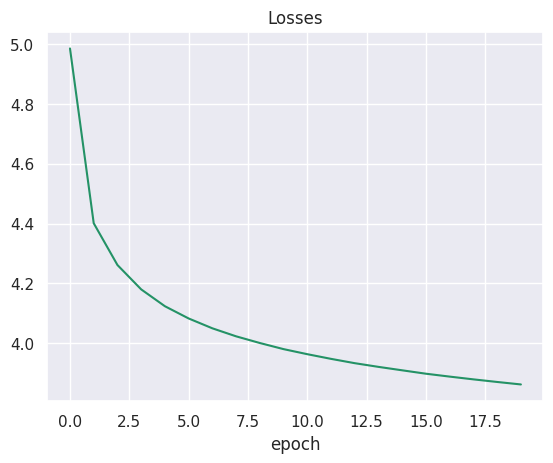

In [36]:
plt.plot(np.arange(len(losses2)), losses2)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

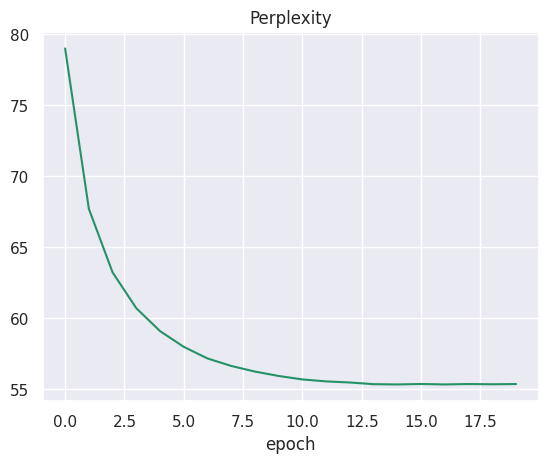

In [37]:
plt.plot(np.arange(len(perplexities1)), perplexities1)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [45]:
import pandas as pd
from datetime import datetime

# Функция для вычисления тестовой перплексии
def calculate_test_perplexity(model, test_dataloader, criterion):
    """Вычисляет перплексию на тестовом наборе"""
    model.eval()
    total_loss = 0
    total_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Calculating test perplexity"):
            logits = model(batch['input_ids'])
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                batch['target_ids'].reshape(-1)
            )
            total_loss += loss.item()
            total_batches += 1
    
    avg_loss = total_loss / total_batches
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

In [47]:
import pandas as pd
from datetime import datetime

results_df = pd.DataFrame(columns=[
    'experiment_name', 
    'model_type',           # LSTM/GRU
    'num_layers',           # количество слоев
    'learning_rate',        # скорость обучения
    'optimizer',            # оптимизатор
    'num_epochs',           # количество эпох
    'final_train_loss',     # финальный loss на обучении
    'final_val_perplexity', # финальная perplexity на валидации
])


results_df = pd.concat([results_df, pd.DataFrame({
    'experiment_name': ["LSTM(1 layer)"],
    'model_type': ["LSTM"],
    'num_layers': [1],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'num_epochs': [20],
'final_train_loss': [losses[-1]],  # последнее значение из твоего обучения
    'final_val_perplexity': [perplexities[-1]]  # последнее значение
})], ignore_index=True)

results_df = pd.concat([results_df, pd.DataFrame({
    'experiment_name': ["GRU"],
    'model_type': ["GRU"], 
    'num_layers': [1],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'num_epochs': [20],
    'final_train_loss': [losses2[-1]],  # последнее значение из твоего обучения
    'final_val_perplexity': [perplexities2[-1]]  # последнее значение
})], ignore_index=True)

results_df = pd.concat([results_df, pd.DataFrame({
    'experiment_name': ["GRU + normalization"],
    'model_type': ["GRU"],
    'num_layers': [1],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'num_epochs': [20],
    'final_train_loss': [losses1[-1]],  # последнее значение
    'final_val_perplexity': [perplexities1[-1]]  # последнее значение
})], ignore_index=True)

results_df = pd.concat([results_df, pd.DataFrame({
    'experiment_name': ["LSTM(2 layers)"],
    'model_type': ["LSTM"],
    'num_layers': [2],
    'learning_rate': [0.001],
    'optimizer': ['AdamW + CosineAnnealingLR'],
    'num_epochs': [20],
    'final_train_loss': [losses3[-1]],  # последнее значение
    'final_val_perplexity': [perplexities3[-1]]  # последнее значение
})], ignore_index=True)


print("ТАБЛИЦА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
display(results_df)


results_df.to_csv('experiments_results.csv', index=False)

ТАБЛИЦА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ


/tmp/ipykernel_36/3441613396.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


,experiment_name,model_type,num_layers,learning_rate,optimizer,num_epochs,final_train_loss,final_val_perplexity
0,LSTM(1 layer),LSTM,1,0.001,Adam,20,4.059068,60.250249
1,GRU,GRU,1,0.001,Adam,20,3.861833,55.927577
2,GRU + normalization,GRU,1,0.001,Adam,20,3.790238,55.359839
3,LSTM(2 layers),LSTM,2,0.001,AdamW + CosineAnnealingLR,20,3.883254,55.004611


1) Видим, что многослойность улучшила качество в случае LSTM(Двухслойный LSTM немного превосходит однослойный GRU)
2)  Нормализация дает небольшое, но стабильное улучшение



Среди данных экспериментов лучшая архитектура **лучшая архитектура: LSTM(2 layers)**
- Perplexity: 55.00 - лучший результат
- AdamW + CosineAnnealingLR - эффективная комбинация
- Два слоя дают преимущество без сильного усложнения